In [132]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle
import json
import string
import re
import warnings
from collections import defaultdict

from random import randint, shuffle
from tqdm import tqdm

import numpy as np
import nltk
import pandas as pd
from nltk import ngrams
from nltk.corpus import stopwords as st

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.models import load_model

seed = 7
np.random.seed(seed)
pd.set_option('max_colwidth', -1)

In [49]:
def plotHist(data, bins=[], x_labels=True):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    if bins: 
        counts, bins, patches = ax.hist(data, bins=bins, facecolor='yellow', edgecolor='gray')
    else:
        counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    if x_labels:
        ax.set_xticks(bins)
        # Set the xaxis's tick labels to be formatted with 1 decimal place...
        ax.xaxis.set_major_formatter(FormatStrFormatter('%0.05f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    if x_labels:
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -18), textcoords='offset points', va='top', ha='center')

            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [84]:
length_class_to_label = {
    0: 'full toss',
    1: 'yorker',
    2: 'full',
    3: 'good length',
    4: 'back of a length',
    5: 'short',
}

line_class_to_label = {
    0: 'wide outside off',
    1: 'outside off',
    2: 'straight',
    3: 'down leg',
    4: 'wide down leg',
}

In [22]:
def load_data(filename):
    with open(f"{filename}.json", "rb") as f:
        data = json.load(f)
    print("Loaded data!")
    return data
        
def load_pkl(filename):
    with open(f"{filename}.pkl", "rb") as f:
        d = pickle.load(f)
    return d
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
        json.dump(data, json_file)
 
i1b = lambda m : m['commentary']['innings1']['balls']
i2b = lambda m : m['commentary']['innings2']['balls']
i1o = lambda m : m['commentary']['innings1']['over_summaries']
i2o = lambda m : m['commentary']['innings2']['over_summaries']

data, players = load_data("matches_Dale Steyn2611"), load_data('player_table')

all_names = set()
ambigNames = set(['short', 'ball', 'head', 'little', 'chase', 'cutting', 'cross'])
for profile in players.values():
    name = profile['known_as'].split(' ')
    ambig = any(n.lower() in ambigNames for n in name)
    if not ambig:
        all_names.update(name)
        all_names.update([n.lower() for n in name])
        
exceptions = ['a', 'off', 'against', 'between', 'into', 'through', 'above', 'below', 'up', 'down', 'out', 'in', 'over', 'further', 'on', 'of']
stopwords = set(st.words('english'))
for w in exceptions:
    stopwords.remove(w) 

Loaded data!
Loaded data!


In [157]:
lineNgrams = load_pkl("line_ngrams")
lengthNgrams = load_pkl("length_ngrams")
vocab = load_pkl("vocab")
lineModel = load_model("line__final_100N_5B_8.h5")
lengthModel = load_model("length__final_100N_5B_4.h5")

In [158]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmas = []
    for w, tag in nltk.pos_tag(text):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemmas.append(lemmatizer.lemmatize(w, wntag) if wntag else w)
    return " ".join(lemmas)

def ngramsInText(text, ngramFeatures):
    ngramPresence = dict()
    for ngram in ngramFeatures:
        ngramSplit = ngram.split(' ')
        ngramPresence[ngram] = int(tuple(ngramSplit) in set(nltk.ngrams(text.split(' '), len(ngramSplit))))
    return pd.Series(ngramPresence).values

def classifyBall(comms):
    tokens = text_to_word_sequence(comms)
    tokens_sw = [w for w in tokens if w in vocab]
    lemmatized = lemmatize_text(tokens_sw)
    xLength = ngramsInText(lemmatized, lengthNgrams)
    xLine = ngramsInText(lemmatized, lineNgrams)
    line = lineModel.predict(np.array([xLine,]))
    length = lengthModel.predict(np.array([xLength,]))
    return line.argmax(axis=1)[0], length.argmax(axis=1)[0]

In [159]:
bowlerPattern = "(?P<bowler>[\w \-'?]+) to (?P<batsman>[\w \-']+),(?P<text_outcome>[^,]*),(?P<desc>.*)$"
for i, m in list(data.items())[301::]:
    for b in i2b(m):
        line, length = classifyBall(b['desc'])
        desc = re.match(bowlerPattern, b['desc']).group('desc')
        tokens = text_to_word_sequence(desc)
        tokens_sw = [w for w in tokens if w in vocab]
        lemmatized = lemmatize_text(tokens_sw)
        print(f"{desc[:75]:>75} | {lemmatized[:75]:>75} | {length_class_to_label[length]:>}, {line_class_to_label[line]:>}")
    break

 hits the deck short of length, around the off stump line, it bounces a tou | deck short of length around off stump line a touch up tall down off side ri | back of a length, outside off
          similar length, but slightly outside off stump, cut down to point |                    similar length slightly outside off stump cut down point | good length, outside off
                                     again short of length, pushed to cover |                                                  short of length push cover | back of a length, outside off
 beaten. Peach of a delivery. Kicked up from a length, Tharanga drives loos |             beaten of a delivery up a length past outside edge big on fails | good length, outside off
 full in length, just outside off stump, left alone. No ugly surprise for M |                           full in length outside off stump leave alone time | good length, outside off
 Ah...not a surprise but a shock for McCullum. Shocker from Franklin. Way d |        

In [60]:
comm_lengths = []
for i, m in tqdm(data.items()):
    total_length = 0
    for b in i1b(m):
        vocab_applied = classifyBall(b['desc'])
        total_length += len(vocab_applied)
    
    numBalls = len(i1b(m))
    if numBalls > 20:
        comm_lengths.append((i, 1, total_length/numBalls))
        
    total_length = 0
    for b in i2b(m):
        vocab_applied = classifyBall(b['desc'])
        total_length += len(vocab_applied)
    
    numBalls = len(i2b(m))
    if numBalls > 20:
        comm_lengths.append((i, 2, total_length/numBalls))
       

100%|██████████| 1869/1869 [00:15<00:00, 117.12it/s]


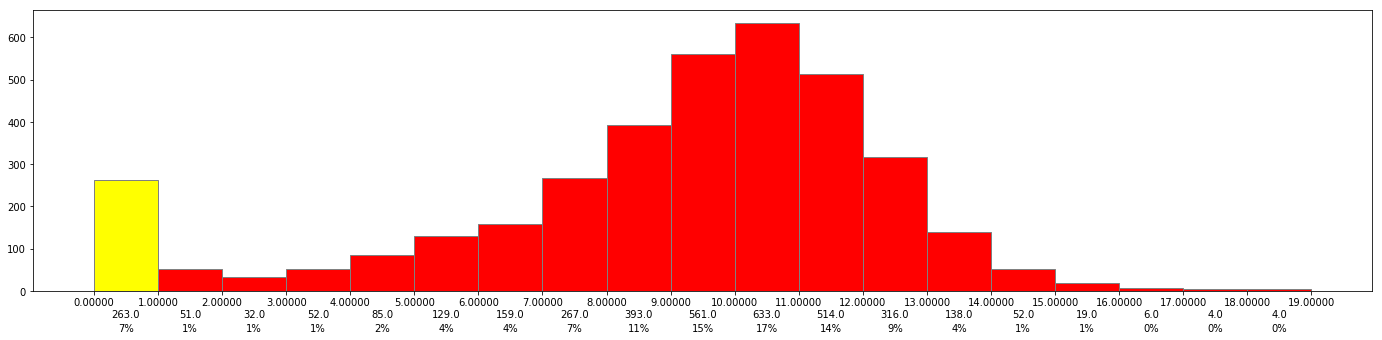

In [61]:
plotHist([x[2] for x in comm_lengths], bins = [x for x in range(20)])

In [64]:
for i, inn, num in comm_lengths:
    f = i1b if i == 1 else i2b
    if num > 1 and num < 4:
        for b in f(data[i]):
            print(b['desc'])
        

Panyangara to Mohammad Rafique, no run,
Panyangara to Mohammad Rafique, no run,
Panyangara to Mohammad Rafique, 1 run,
Panyangara to Nafees Iqbal, no run,
Panyangara to Nafees Iqbal, no run,
Panyangara to Nafees Iqbal, no run,
Mpofu to Mohammad Rafique, 1 run,
Mpofu to Nafees Iqbal, FOUR runs,
Mpofu to Nafees Iqbal, 1 run,
Mpofu to Mohammad Rafique, no run,
Mpofu to Mohammad Rafique, no run,
Mpofu to Mohammad Rafique, no run,
Panyangara to Nafees Iqbal, FOUR runs,
Panyangara to Nafees Iqbal, no run,
Panyangara to Nafees Iqbal, no run,
Panyangara to Nafees Iqbal, no run,
Panyangara to Nafees Iqbal, OUT,,Nafees Iqbal b Panyangara 9 (12m 10b 2x4 0x6) SR: 90.00
Panyangara to Aftab Ahmed, 1 wide,
Panyangara to Aftab Ahmed, no run,
Mpofu to Mohammad Rafique, 1 run,
Mpofu to Aftab Ahmed, no run,
Mpofu to Aftab Ahmed, FOUR runs,
Mpofu to Aftab Ahmed, no run,
Mpofu to Aftab Ahmed, 1 run,
Mpofu to Mohammad Rafique, no run,
Panyangara to Aftab Ahmed, no run,
Panyangara to Aftab Ahmed, no run,
Pan